In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_LA = pd.read_csv(r"F:\wenqu\DOE_Arctic_project\spectral\combine_LA.csv")

In [3]:
b_name_mean = []
b_name_std = []
for i in range(1, 123):
    b_mean = 'b' + str(i) + '_mean'
    b_name_mean.append(b_mean)
    b_std = 'b' + str(i) + '_std'
    b_name_std.append(b_std)
band_name = b_name_mean + b_name_std

In [4]:
x_la = df_LA[band_name]
y_weighted_la = df_LA['weighted_la']
log_y_weighted_la = np.log(y_weighted_la)

vol_mois_la = df_LA['vol_moisture']

LA_n_2a = 28
LA_n_1b = 52
LA_n_2c = 57
LA_n_6 = 65

In [5]:
x_la = x_la.to_numpy()
x_la.shape


(64, 244)

In [6]:
band_name = np.array(band_name)

In [7]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
 
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    plt.imshow(mse, interpolation=None)
    plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [8]:
def simple_pls_cv(X, y, n_comp, vol_mois, n_2a, n_1b, n_2c,n_6):
 
    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)    
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression 
 
    z = np.polyfit(y, y_cv, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        
#         ax.scatter(y_cv, y, c='red', edgecolors='k')
        
        ax.scatter(y_cv[0:n_2a, ], y[0:n_2a, ], c=vol_mois[0:n_2a, ],  cmap='Spectral', marker= '*',edgecolors='k')
        ax.scatter(y_cv[n_2a:n_1b, ], y[n_2a:n_1b, ], c=vol_mois[n_2a:n_1b, ],  cmap='Spectral', marker= 'v',edgecolors='k')
        ax.scatter(y_cv[n_1b:n_2c, ], y[n_1b:n_2c, ], c=vol_mois[n_1b:n_2c, ],  cmap='Spectral', marker= '.',edgecolors='k')
        ax.scatter(y_cv[n_2c:n_6, ], y[n_2c:n_6, ], c=vol_mois[n_2c:n_6, ],  cmap='Spectral', marker= 'P',edgecolors='k')
        
        
        ax.plot(z[1]+z[0]*y, y, c='blue', linewidth=1)
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        
        plt.show()

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


5% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


10% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


15% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


20% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


25% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


30% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


35% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


40% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


45% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


50% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


55% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


60% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


65% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


70% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


75% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


80% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


85% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


90% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


95% completed

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


100% completed
Optimised number of PLS components:  12
Wavelengths to be discarded  215
Optimised MSEP  0.31097104339275405



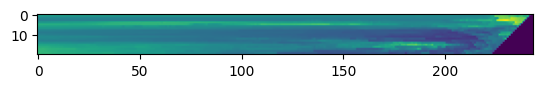

R2 calib: 0.905
R2 CV: 0.782
MSE calib: 0.129
MSE CV: 0.293


C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


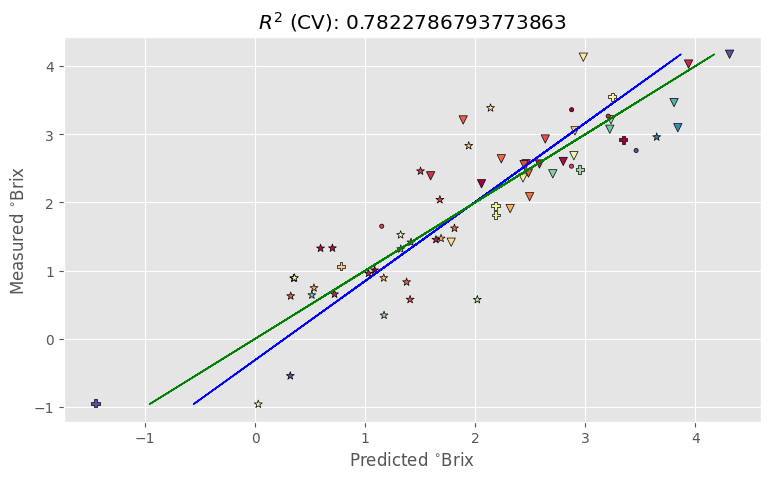

In [9]:
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_la, log_y_weighted_la, 20)
simple_pls_cv(opt_Xc, log_y_weighted_la, ncomp, vol_mois_la,LA_n_2a, LA_n_1b,  LA_n_2c, LA_n_6)

In [8]:
pls2 = PLSRegression(n_components = 12)
pls2.fit(x_la, log_y_weighted_la)
y_c = pls2.predict(x_la)
score_c = r2_score(log_y_weighted_la, y_c)

In [9]:
score_c

0.8999292992542594

In [11]:
sorted_ind = np.argsort(np.abs(pls2.coef_[:,0]))
sorted_ind.shape
# Sort spectra accordingly 
# Xc = x_la[:,sorted_ind]

(244,)

In [25]:
pls2.coef_[sorted_ind][-29:]

array([[ 0.31556117],
       [-0.31637021],
       [ 0.31906054],
       [-0.32124573],
       [-0.34298296],
       [ 0.35107985],
       [ 0.35511357],
       [-0.37369869],
       [ 0.40436503],
       [-0.42575138],
       [ 0.42951007],
       [-0.44072882],
       [ 0.44077624],
       [ 0.44462493],
       [ 0.46096893],
       [-0.47356007],
       [-0.47666208],
       [-0.49608825],
       [-0.51741251],
       [ 0.52290846],
       [ 0.53326185],
       [-0.62110612],
       [-0.66670289],
       [-0.6780343 ],
       [ 0.6865758 ],
       [ 0.78510398],
       [ 0.89266821],
       [ 0.94437587],
       [-0.97321584]])

In [12]:
sorted_ind

array([ 85, 222,  35,  38,  92, 154, 165,  52, 213, 151, 157,  73,  43,
       166,  13,  30, 201, 203, 141,  37,  91, 174,  68, 167, 142, 171,
       223, 198,  80, 191, 176,   7,  19,  23, 232,  47,  48,  46, 144,
        27, 240, 214, 102,  20,  24,  39, 208,  55, 170,  78,  18,  57,
       180, 101, 114,  88,  67, 134,  95, 227, 237,  58,  45,  93,  42,
        26, 135,  32, 209,  69, 220,  21, 193, 210,  49, 205, 161, 206,
       192, 235, 136, 179, 218,  56,  96, 202,  31, 103,  94,  83,  54,
        60, 215,  82, 199, 160, 217,  28,  51,  53, 189,  81,  98,   8,
       181, 143, 121,  22,  44,  77,  84,  34, 200,  36,  97,  79,  72,
        17, 140,  50, 216,  41,  70, 169, 137,  25, 168,  76,  89,  86,
        16, 126,  33,  90, 158,  71,  66,   5, 207, 117, 195, 197,  61,
       159,  99,  87, 211,   2,  15,  65, 230,  40, 138, 172, 190, 105,
       150,  10, 132, 130,  59, 188, 163, 194, 239, 178, 221,  75, 164,
       233, 183, 182, 212,  29, 116, 175, 128,  11, 204, 219, 15

In [16]:
x_la

array([[0.02513029, 0.02134852, 0.01770818, ..., 0.05316708, 0.05993119,
        0.06688997],
       [0.0371157 , 0.02813619, 0.02755567, ..., 0.14341609, 0.13250755,
        0.15794219],
       [0.00913065, 0.01448597, 0.0093588 , ..., 0.07574262, 0.07788602,
        0.08915306],
       ...,
       [0.0004745 , 0.00355525, 0.00524099, ..., 0.02115562, 0.02188501,
        0.0328268 ],
       [0.0028907 , 0.00377008, 0.00597508, ..., 0.02170419, 0.02515271,
        0.04609478],
       [0.00512919, 0.00466271, 0.00570549, ..., 0.02414475, 0.02802827,
        0.03947566]])

In [18]:
optimal_band = band_name[sorted_ind]
optimal_band


array(['b86_mean', 'b101_std', 'b36_mean', 'b39_mean', 'b93_mean',
       'b33_std', 'b44_std', 'b53_mean', 'b92_std', 'b30_std', 'b36_std',
       'b74_mean', 'b44_mean', 'b45_std', 'b14_mean', 'b31_mean',
       'b80_std', 'b82_std', 'b20_std', 'b38_mean', 'b92_mean', 'b53_std',
       'b69_mean', 'b46_std', 'b21_std', 'b50_std', 'b102_std', 'b77_std',
       'b81_mean', 'b70_std', 'b55_std', 'b8_mean', 'b20_mean',
       'b24_mean', 'b111_std', 'b48_mean', 'b49_mean', 'b47_mean',
       'b23_std', 'b28_mean', 'b119_std', 'b93_std', 'b103_mean',
       'b21_mean', 'b25_mean', 'b40_mean', 'b87_std', 'b56_mean',
       'b49_std', 'b79_mean', 'b19_mean', 'b58_mean', 'b59_std',
       'b102_mean', 'b115_mean', 'b89_mean', 'b68_mean', 'b13_std',
       'b96_mean', 'b106_std', 'b116_std', 'b59_mean', 'b46_mean',
       'b94_mean', 'b43_mean', 'b27_mean', 'b14_std', 'b33_mean',
       'b88_std', 'b70_mean', 'b99_std', 'b22_mean', 'b72_std', 'b89_std',
       'b50_mean', 'b84_std', 'b40_std'

In [19]:
optimal_band = band_name[sorted_ind][-29:]
optimal_band

array(['b52_std', 'b34_std', 'b107_std', 'b8_std', 'b32_std', 'b119_mean',
       'b65_std', 'b2_mean', 'b121_mean', 'b75_mean', 'b120_mean',
       'b1_mean', 'b26_std', 'b10_std', 'b120_std', 'b4_std', 'b15_mean',
       'b103_std', 'b110_mean', 'b5_mean', 'b107_mean', 'b105_std',
       'b109_mean', 'b3_std', 'b12_std', 'b108_mean', 'b4_mean',
       'b108_std', 'b122_std'], dtype='<U9')

In [20]:
x_la_optimal = df_LA[optimal_band]
x_la_optimal.shape

(64, 29)

In [21]:
pls3 = PLSRegression(n_components = 12)
pls3.fit(x_la_optimal, log_y_weighted_la)
y_c = pls3.predict(x_la_optimal)
score_c = r2_score(log_y_weighted_la, y_c)
score_c

0.9046593010426331

In [22]:
pls3.coef_.shape

C:\Users\15086\anaconda3\envs\wenqu_gdal\lib\site-packages\sklearn\cross_decomposition\_pls.py:503: FutureWarning: The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
  warnings.warn(


(29, 1)

In [24]:
pls3.coef_

array([[-0.64570444],
       [-0.83750744],
       [ 0.83505827],
       [-0.99145006],
       [-0.62330507],
       [ 0.06780459],
       [ 1.56084937],
       [-0.85337594],
       [ 0.42475524],
       [-0.64674977],
       [ 0.78252502],
       [-0.48933805],
       [ 1.75513954],
       [ 0.17894097],
       [ 1.05435687],
       [-0.53853918],
       [-1.27749178],
       [-1.17019249],
       [-1.43608457],
       [ 0.92612388],
       [ 0.94560618],
       [-1.25903758],
       [-0.87856942],
       [-0.42104026],
       [ 1.35965638],
       [ 1.48255907],
       [ 1.17742143],
       [-0.03216254],
       [-0.73239041]])

In [23]:
pls4 = PLSRegression(n_components = 12)
y_cv = cross_val_predict(pls4, x_la_optimal, log_y_weighted_la, cv=10) 
score_cv = r2_score(log_y_weighted_la, y_cv)
score_cv

0.7822786793773869